In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import chardet
import sys, os

In [3]:
%reload_ext watermark
%watermark -a "Leonardo da Silva Neves"

Author: Leonardo da Silva Neves



In [4]:
# Carregando DataFrames das edições do censo da educação superior.
c_cursos = 'bases_consolidadas/censo_ead_v2.csv'
d_cursos = 'bases_consolidadas/detalhe_cursos.xlsx'
l_oferta = 'bases_consolidadas/local_oferta.csv'

In [16]:
files = [c_cursos, l_oferta]

In [17]:
def extrair(list):

    for i in list:
        with open(i, 'rb') as f:
            raw = f.read(1000000)

        result = chardet.detect(raw)
        cod = result['encoding']
        conf = result['confidence']
    
        print(f' Codificação: {cod} com confiança: {conf}%')    

In [18]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

In [19]:
# Descobrinso o tipo de codificação dos arquivos .csv
extrair(files)

 Codificação: ISO-8859-1 com confiança: 0.73%
 Codificação: UTF-8-SIG com confiança: 1.0%


In [20]:
df_c = pd.read_csv(c_cursos, sep=';', encoding='ISO-8859-1', low_memory=False, decimal=',')

In [21]:
df_lo = pd.read_csv(l_oferta, sep=';', encoding='UTF-8-SIG', low_memory=False, decimal=',')

In [22]:
df_dc = pd.read_excel(d_cursos)

In [24]:
na = (df_dc.isna().mean()*100).round(2)

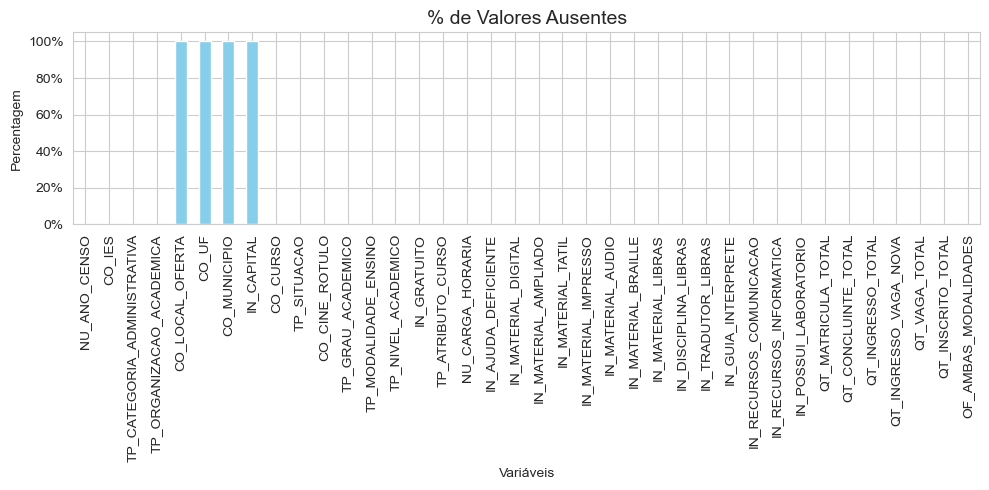

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))

na.plot(kind='bar', color='skyblue')

plt.title('% de Valores Ausentes', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Percentagem')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()

plt.savefig(fname='porcentagem_valores_ausentes.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Explosão da Demanda (Gestores e Imprensa)

**O que mostrar**: O desempenho entre o aumento de inscritos e a capacidade de retenção (concluintes)

In [30]:
# Agrupando por ano
eixo_fluxo = df_c.groupby('NU_ANO_CENSO', observed=False).agg({
    'QT_INSCRITO_TOTAL_EAD': 'sum',
    'QT_ING': 'sum',
    'QT_MAT': 'sum',
    'QT_CONC': 'sum'
}).reset_index()

**Impriminto em pdf**

In [33]:
from pandas.plotting import table

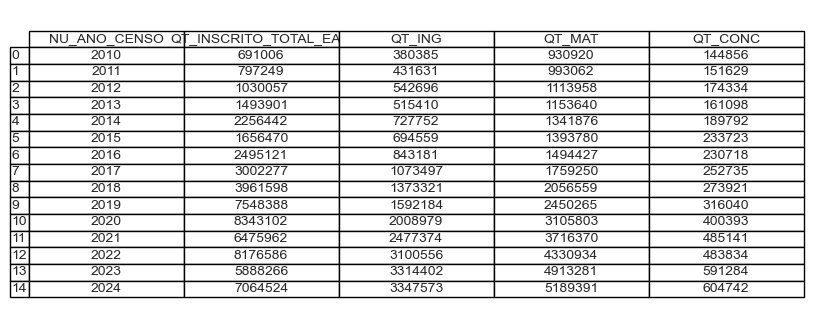

In [36]:
eixo_fluxo

fig, ax = plt.subplots(figsize=(10,4))
ax.axis('off') # Escondendo os eixos dos gráficos

# Criando a tabela dentro do gráfico
tbl = table(ax, eixo_fluxo, loc='center', cellLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)

plt.savefig(fname='tabela_agruapamento_qtde_anual.pdf', bbox_inches='tight')


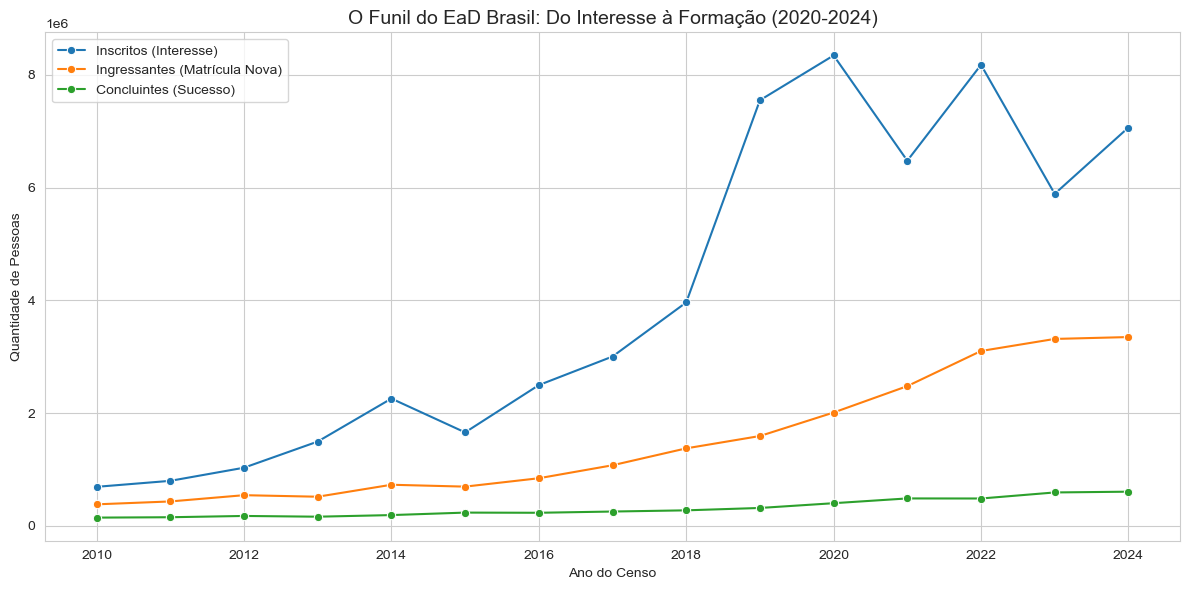

In [38]:
# Gráfico de linhas múltiplas
plt.figure(figsize=(12,6))
sns.lineplot(data=eixo_fluxo, x='NU_ANO_CENSO', y='QT_INSCRITO_TOTAL_EAD', marker='o', label='Inscritos (Interesse)')
sns.lineplot(data=eixo_fluxo, x='NU_ANO_CENSO', y='QT_ING', marker='o', label='Ingressantes (Matrícula Nova)')
sns.lineplot(data=eixo_fluxo, x='NU_ANO_CENSO', y='QT_CONC', marker='o', label='Concluintes (Sucesso)')

plt.title('O Funil do EaD Brasil: Do Interesse à Formação (2020-2024)', fontsize=14)
plt.ylabel('Quantidade de Pessoas')
plt.xlabel('Ano do Censo')
plt.legend()
plt.tight_layout()
plt.savefig(fname='funil_ead_brasil.pdf', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

### Perfil Étnico e Financiamento (Pesquisadores e Gestores)

**O que mostrar**: O EaD Está incluindo mais pessoas preta e pardas? O PROUNI é o motor disso?

In [39]:
# Proporção de alunos por raça e uso do PROUNI
perfil_social = df_c.groupby('NU_ANO_CENSO', observed=False).agg({
    'QT_MAT_PRETA': 'sum',
    'QT_MAT_PARDA': 'sum',
    'QT_MAT_PROUNII': 'sum',
    'QT_MAT': 'sum'
}).reset_index()

perfil_social['PCT_NEGROS_PARDOS'] = ((perfil_social['QT_MAT_PRETA'] + perfil_social['QT_MAT_PARDA']) / perfil_social['QT_MAT'])*100
perfil_social['PCT_PROUNI'] = (perfil_social['QT_MAT_PROUNII'] / perfil_social['QT_MAT'])*100

In [49]:
!pip install fpdf2 -U

In [48]:
# !python.exe -m pip install --upgrade pip

In [51]:
from fpdf import FPDF

# Configurando o PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("helvetica", size=12)

# Criando um tabela (simples)
with pdf.table() as table:
    # Cabeçalho
    row = table.row()
    for col in perfil_social.columns:
        row.cell(col)

    # Dados
    for r in perfil_social.itertuples(index=False):
        row = table.row()
        for datum in r:
            row.cell(str(datum))

pdf.output('agrupamento_perfil_social.pdf')
print('PDF gerado com sucesso!')

PDF gerado com sucesso!


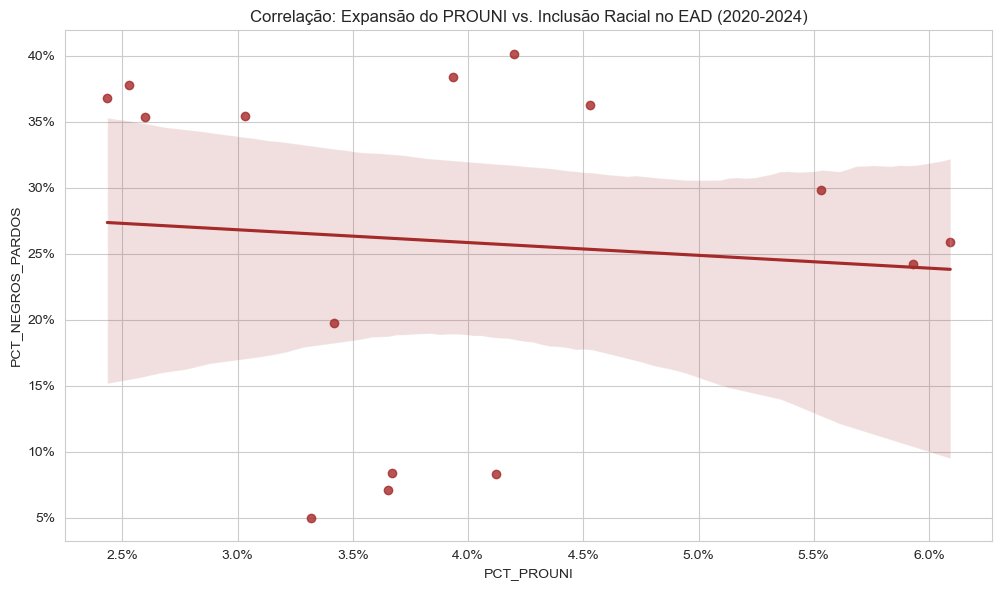

In [67]:
# Gráfico de dispersão com linha de tendência
plt.figure(figsize=(10,6))
sns.regplot(data=perfil_social, x='PCT_PROUNI' ,y='PCT_NEGROS_PARDOS', color='brown')
plt.title('Correlação: Expansão do PROUNI vs. Inclusão Racial no EAD (2020-2024)')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.show()

### Acessibilidade Digital vs. Física (Alunos e Pesquisadores)

Aqui vamos cruzar os dados de Infraestrutura do Polo com os Materiais do Curso.

In [55]:
na1 = (df_dc.isna().mean()*100).round(2)

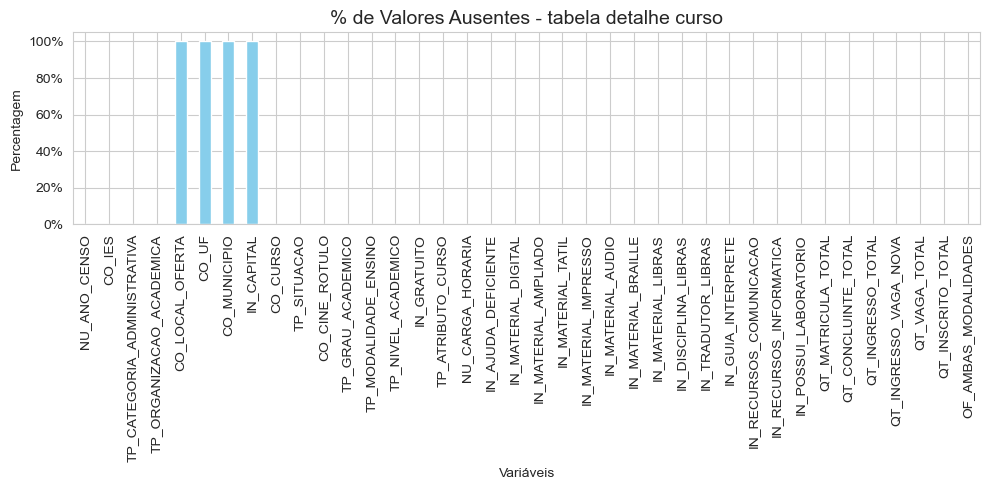

In [58]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))

na1.plot(kind='bar', color='skyblue')

plt.title('% de Valores Ausentes - tabela detalhe curso', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Percentagem')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()

plt.savefig(fname='%_valores_ausentes_detalhe_curso.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [68]:
# Passo1 - Médias de acessibilidade digital
dig = df_dc.groupby('NU_ANO_CENSO', observed=False).agg({
    'IN_MATERIAL_LIBRAS': 'mean',
    'IN_MATERIAL_DIGITAL': 'mean'
})*100

In [88]:
na2 = (df_lo.isna().mean()*100).round(2)

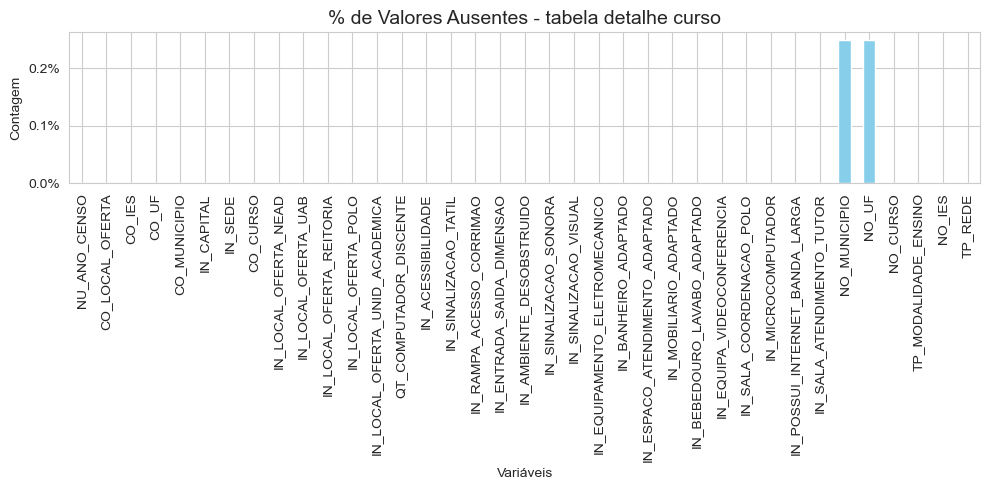

In [89]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))

na2.plot(kind='bar', color='skyblue')

plt.title('% de Valores Ausentes - tabela detalhe curso', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Contagem')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.tight_layout()

#plt.savefig(fname='%_valores_ausentes_local_oferta.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [85]:
# Passo2 - Calcular as médias de acessibilidade física
fis = df_lo.groupby('NU_ANO_CENSO', observed=False).agg({
    'IN_ACESSIBILIDADE': 'mean',
    'IN_POSSUI_INTERNET_BANDA_LARGA': 'mean'
}) * 100

In [86]:
# Criando a tabela final de Acessibilidade (Dashboard)
dash = pd.concat([dig, fis], axis=1).reset_index()

dash = dash.round(1)

dash

,NU_ANO_CENSO,IN_MATERIAL_LIBRAS,IN_MATERIAL_DIGITAL,IN_ACESSIBILIDADE,IN_POSSUI_INTERNET_BANDA_LARGA
0,2020,57.2,73.8,77.9,77.8
1,2021,66.6,75.1,83.7,82.8
2,2022,70.9,87.6,84.6,85.2
3,2023,69.7,85.5,83.3,83.9
4,2024,67.9,87.6,86.4,87.0


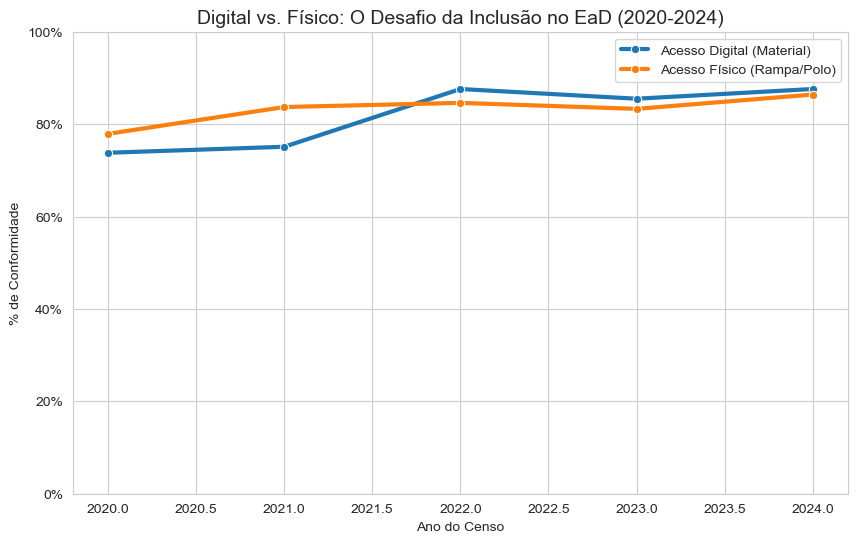

In [91]:
plt.figure(figsize=(10,6))

sns.lineplot(data=dash, x='NU_ANO_CENSO', y='IN_MATERIAL_DIGITAL', marker='o', label='Acesso Digital (Material)', linewidth=3)
sns.lineplot(data=dash, x='NU_ANO_CENSO', y='IN_ACESSIBILIDADE', marker='o', label='Acesso Físico (Rampa/Polo)', linewidth=3)

plt.title('Digital vs. Físico: O Desafio da Inclusão no EaD (2020-2024)', fontsize=14)
plt.ylabel('% de Conformidade')
plt.xlabel('Ano do Censo')
plt.ylim(0,100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.savefig(fname='digitalvsfisico.pdf', dpi=300, bbox_inches='tight')
plt.show()

**1. Aluno e Imprensa**

O foco é representatividade: "Eu me vejo neste ambiente?" e "O EAD está se tornando mais diverso?"

In [92]:
cols = ['QT_VG_TOTAL', 'QT_VG_TOTAL_DIURNO', 'QT_VG_TOTAL_NOTURNO',
       'QT_INSCRITO_TOTAL', 'QT_INSCRITO_TOTAL_DIURNO', 'QT_INSCRITO_TOTAL_NOTURNO',
       'QT_ING_DIURNO', 'QT_ING_NOTURNO', 'QT_MAT_DIURNO', 'QT_MAT_NOTURNO',
       'QT_CONC_DIURNO', 'QT_CONC_NOTURNO']

df_c.drop(columns=cols, errors='ignore', inplace=True)

In [93]:
df_c.rename(columns={'QT_CONC_PRETA.1': 'QT_CONC_PARDA'}, inplace=True)

In [94]:
# Criando colunas de agrupamento racial e financiamento
df_c['QT_MAT_NEGROS'] = df_c['QT_MAT_PRETA'] + df_c['QT_MAT_PARDA']
df_c['QT_ING_NEGROS'] = df_c['QT_ING_PRETA'] + df_c['QT_ING_PARDA']
df_c['QT_CONC_NEGROS'] = df_c['QT_CONC_PRETA'] + df_c['QT_CONC_PARDA']
df_c['QT_PROUNI_TOTAL'] = df_c['QT_MAT_PROUNII'] + df_c['QT_MAT_PROUNIP']

In [95]:
sns.set_theme(style="whitegrid")

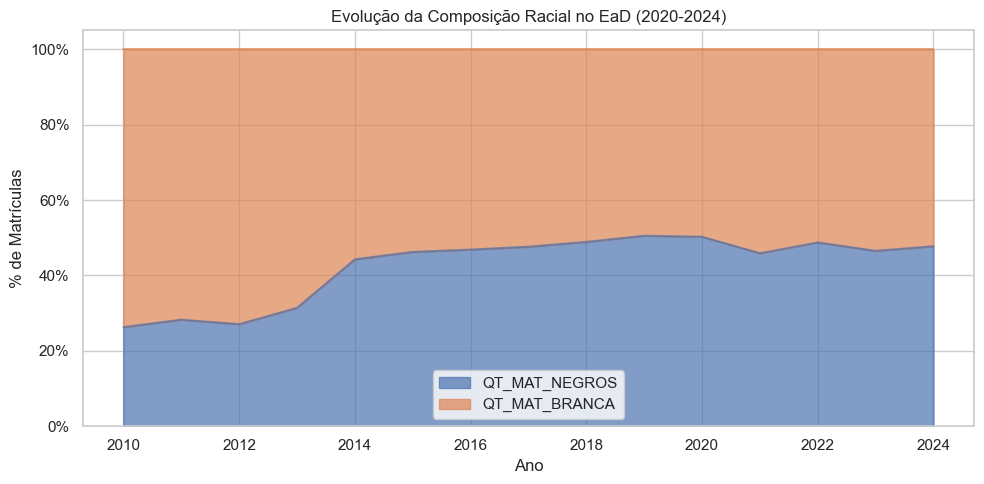

In [97]:
# 1.1 Curva de diversidade (stacked Area)
resumo_raca = df_c.groupby('NU_ANO_CENSO', observed=True).agg({
    'QT_MAT_NEGROS':'sum',
    'QT_MAT_BRANCA': 'sum'
})

resumo_raca_pct = resumo_raca.div(resumo_raca.sum(axis=1), axis=0) * 100



resumo_raca_pct.plot(kind='area', stacked=True, figsize=(10, 5), alpha=0.7)
plt.title('Evolução da Composição Racial no EaD (2020-2024)')
plt.ylabel('% de Matrículas')
plt.xlabel('Ano')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.savefig(fname='evolucao_composicao_racial', dpi=300, bbox_inches='tight')
plt.show()

In [117]:
df_c24 = df_c[df_c['NU_ANO_CENSO'] == 2024].copy()

In [118]:
# 1.2 Top 10 por % de alunos negros (2024)
top_areas = df_c24.groupby('NO_CINE_AREA_GERAL', observed=True).agg({
    'QT_MAT_NEGROS':'sum',
    'QT_MAT': 'sum'
})

top_areas['PCT_NEGROS'] = (top_areas['QT_MAT_NEGROS'] / top_areas['QT_MAT']) * 100
top_areas = top_areas.sort_values('PCT_NEGROS', ascending=False).head(10).reset_index()

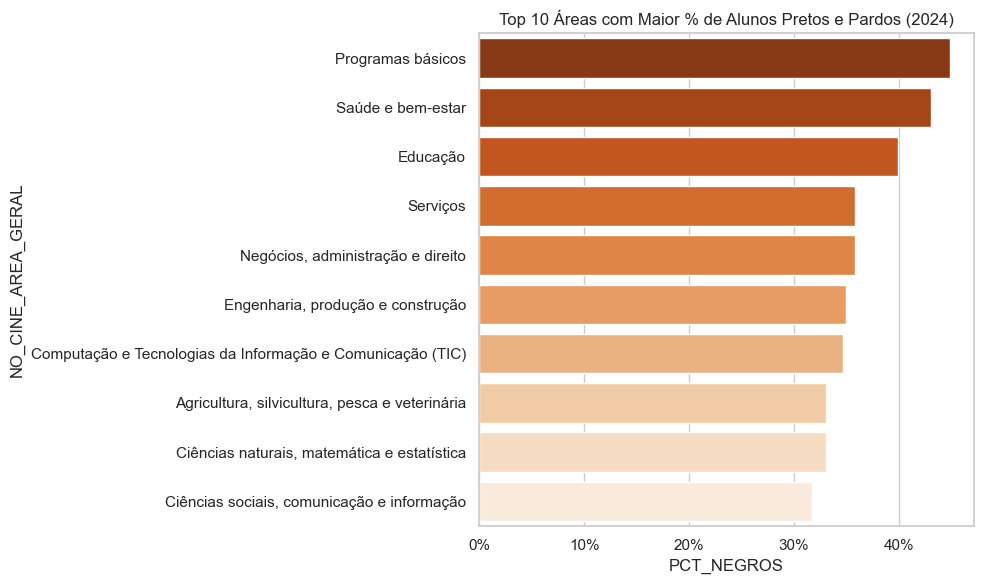

In [119]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_areas, x='PCT_NEGROS', y='NO_CINE_AREA_GERAL', palette='Oranges_r', hue='NO_CINE_AREA_GERAL')
plt.title('Top 10 Áreas com Maior % de Alunos Pretos e Pardos (2024)')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.tight_layout()
plt.savefig(fname='to_10_area_pretos_pardos', dpi=300, bbox_inches='tight')
plt.show()

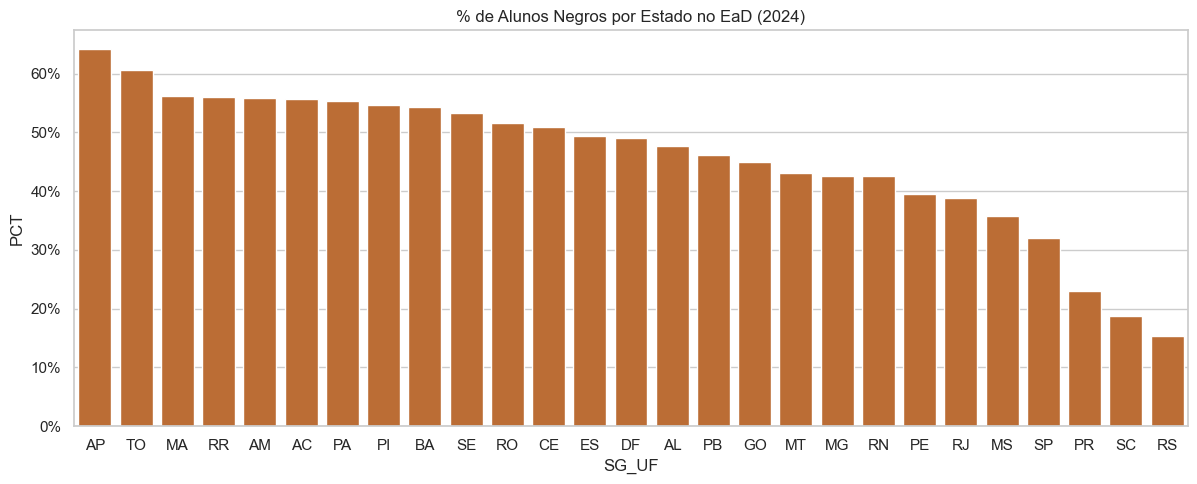

In [120]:
# 1.3 Mapa de Inclusão por Estado (Representado por Barras)

uf_raca = df_c24.groupby('SG_UF', observed=True).agg({
    'QT_MAT_NEGROS': 'sum',
    'QT_MAT': 'sum'
})

uf_raca['PCT'] = (uf_raca['QT_MAT_NEGROS'] / uf_raca['QT_MAT']) * 100
uf_raca = uf_raca.sort_values('PCT', ascending=False).reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(data=uf_raca, x='SG_UF', y='PCT', color='chocolate')
plt.title('% de Alunos Negros por Estado no EaD (2024)')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig(fname='%_alunos_negros_estado', dpi=300, bbox_inches='tight')
plt.show()

**2. Gestores e Governança**

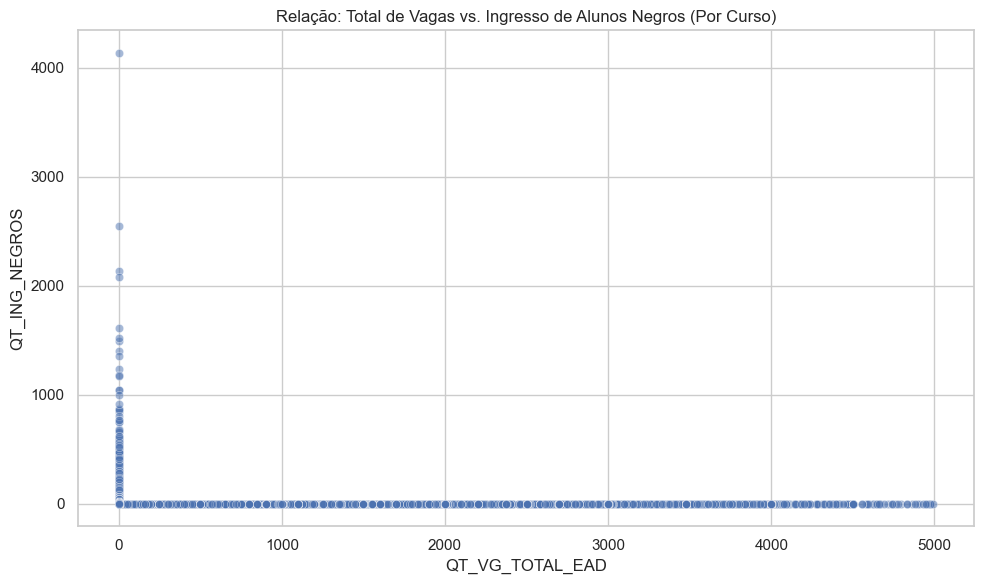

In [121]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_c24[df_c24['QT_VG_TOTAL_EAD'] < 5000],
               x='QT_VG_TOTAL_EAD', y='QT_ING_NEGROS', alpha=0.5)
plt.title('Relação: Total de Vagas vs. Ingresso de Alunos Negros (Por Curso)')
plt.tight_layout()
plt.show()

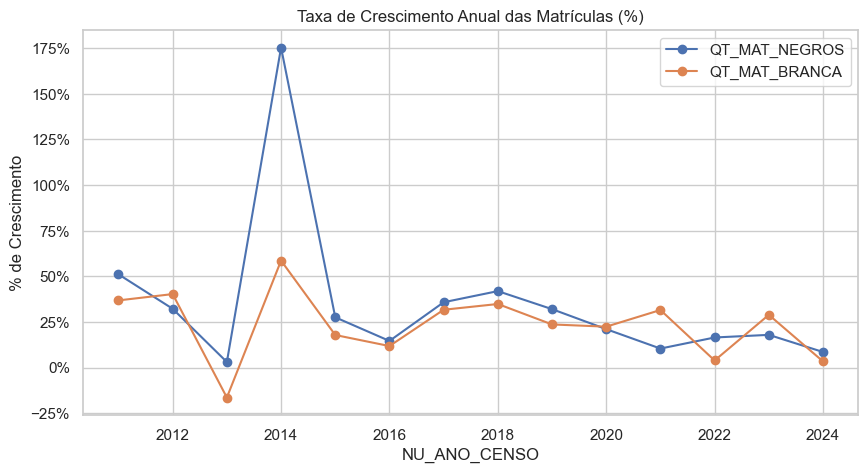

In [106]:
# Crescimento anual comparativo
growth = df_c.groupby('NU_ANO_CENSO').agg({
    'QT_MAT_NEGROS': 'sum', 'QT_MAT_BRANCA': 'sum'
}).pct_change() * 100

growth.plot(figsize=(10, 5), marker='o')
plt.title('Taxa de Crescimento Anual das Matrículas (%)')
plt.ylabel('% de Crescimento')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig(fname='taxa_crescimento_matricula', dpi=300, bbox_inches='tight')
plt.show()

**3. Pesquisadores**

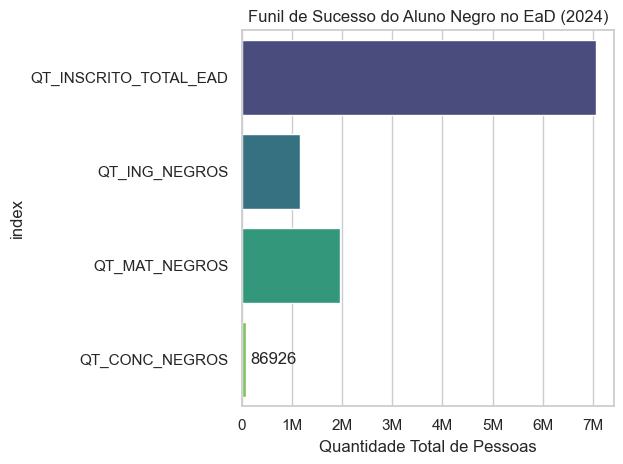

In [122]:
funil = df_c24.agg({
    'QT_INSCRITO_TOTAL_EAD': 'sum',
    'QT_ING_NEGROS': 'sum',
    'QT_MAT_NEGROS': 'sum',
    'QT_CONC_NEGROS': 'sum'
}).reset_index()

# Função para formatar os números em milhões
def milhoes(x, pos):
    val = abs(x) * 1e-6
    if val == 0: return "0"
    return f'{val:.0f}M'

ax = sns.barplot(data=funil, x=0, y='index', palette='viridis', hue='index')
ax.bar_label(ax.containers[3], fmt='%.0f', padding=3)

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhoes))
plt.title('Funil de Sucesso do Aluno Negro no EaD (2024)')
plt.xlabel('Quantidade Total de Pessoas')
plt.tight_layout()
plt.savefig('funil_sucesso_negros', dpi=300, bbox_inches='tight')
plt.show()

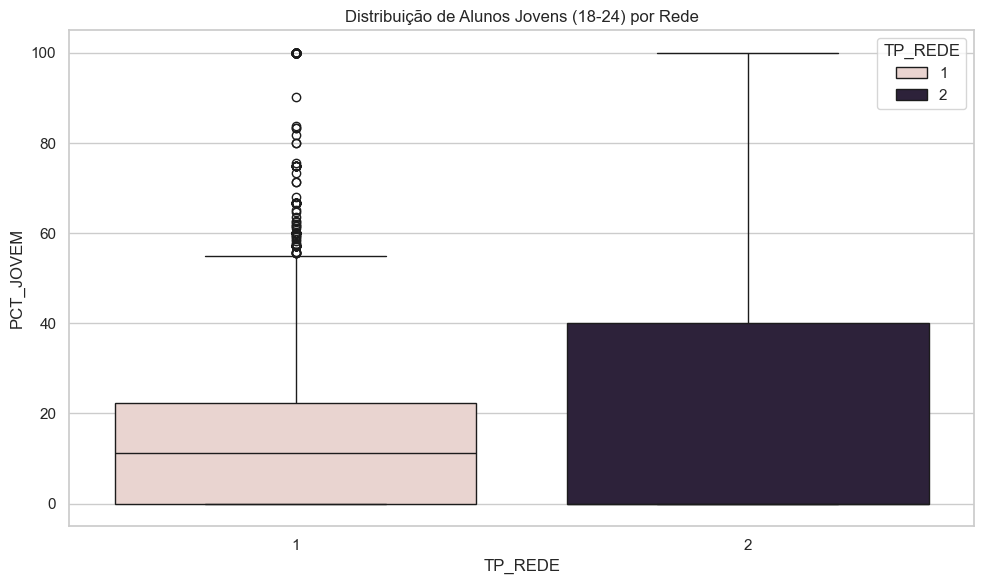

In [123]:
# Idade vs. Raça
df_c24['PCT_JOVEM'] = (df_c24['QT_MAT_18_24'] / df_c24['QT_MAT']) * 100
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_c24, x='TP_REDE', y='PCT_JOVEM', hue='TP_REDE')
plt.title('Distribuição de Alunos Jovens (18-24) por Rede')
plt.tight_layout()
plt.show()

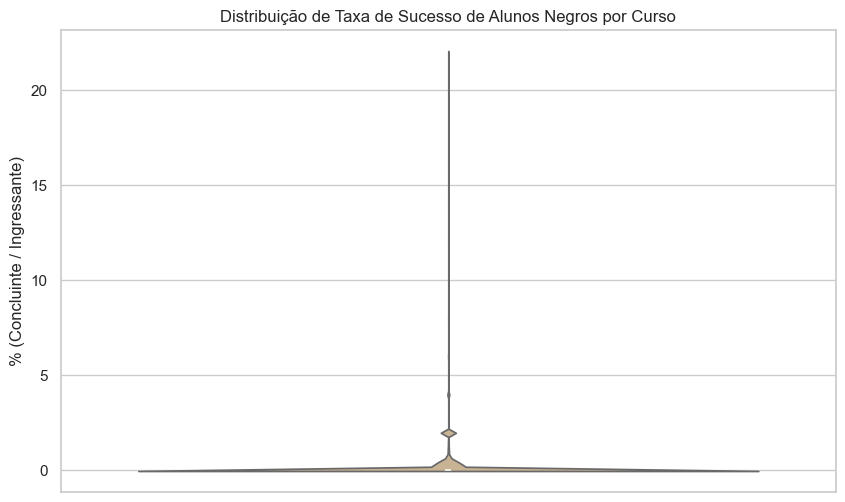

In [125]:
# 3.3 Índice de Sucesso (Concluintes / Ingressantes)
# Evitar divisão por zero
df_c24_valid = df_c24[df_c24['QT_ING_NEGROS'] > 0].copy()
df_c24_valid['TAXA_SUCESSO_NEGROS'] = (df_c24_valid['QT_CONC_NEGROS'] / df_c24_valid['QT_ING_NEGROS']) # *100

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_c24_valid[df_c24_valid['TAXA_SUCESSO_NEGROS'] <= 100],
               y='TAXA_SUCESSO_NEGROS', color='tan')

plt.title('Distribuição de Taxa de Sucesso de Alunos Negros por Curso')
plt.ylabel('% (Concluinte / Ingressante)')
plt.show()

In [126]:
# 1. Quem se forma mais: Homens ou Mulheres e em quais idades?

In [127]:
total_genero = {
    'Gênero': ['Feminino', 'Masculino'],
    'Total': [df_c24['QT_CONC_FEM'].sum(), df_c24['QT_CONC_MASC'].sum()]
}
df_gen = pd.DataFrame(total_genero)

In [129]:
colunas_idade = ['QT_CONC_18_24', 'QT_CONC_25_29', 'QT_CONC_30_34',
                'QT_CONC_35_39', 'QT_CONC_40_49', 'QT_CONC_50_59', 'QT_CONC_60_MAIS']

labels_idade = ['18-24', '25-29', '30-34', '35-39', '40-49', '50-59', '60+']

df_idade = pd.DataFrame({
    'Faixa Etária': labels_idade,
    'Concluintes': [df_c24[col].sum() for col in colunas_idade]
})

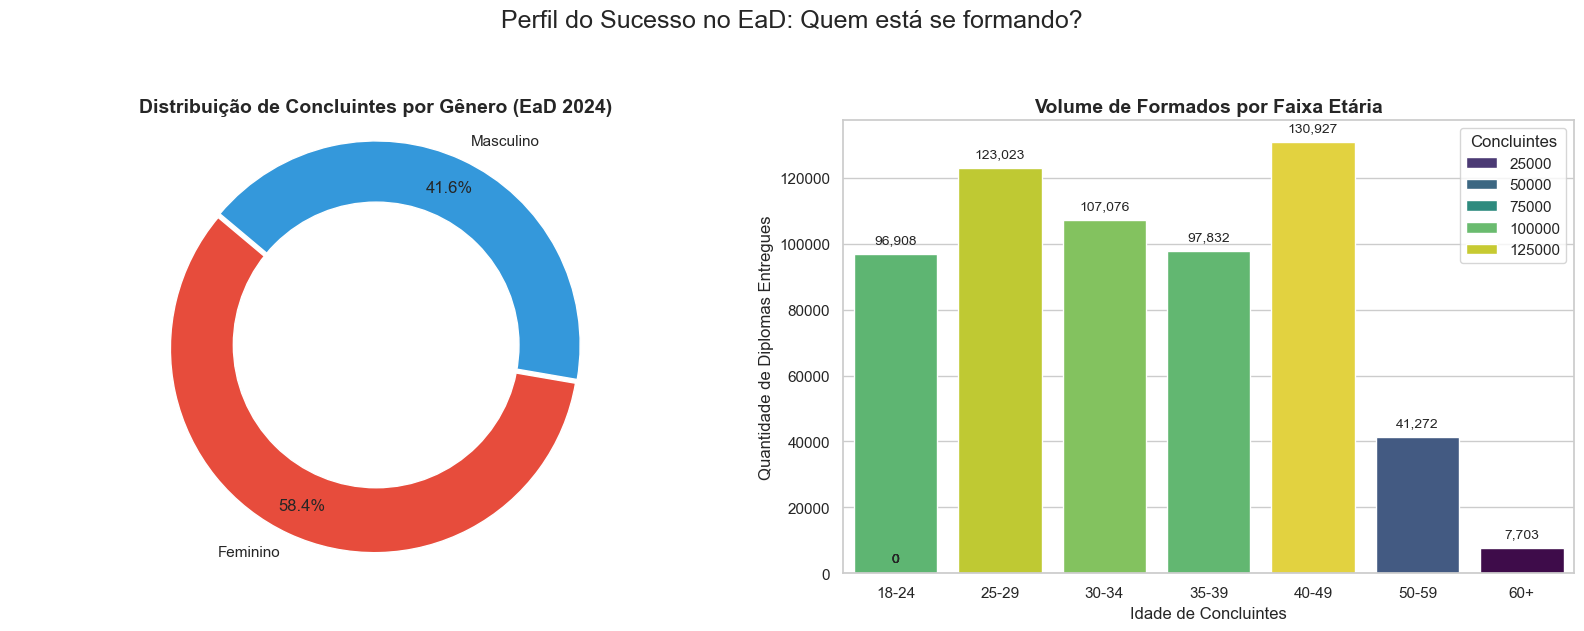

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.3)

colors_gen = ['#e74c3c', '#3498db']
ax1.pie(df_gen['Total'], labels=df_gen['Gênero'], autopct='%1.1f%%',
        startangle=140, colors=colors_gen, pctdistance= 0.85, explode=(0.02, 0))

centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax1.add_artist(centre_circle)
ax1.set_title('Distribuição de Concluintes por Gênero (EaD 2024)', fontsize=14, fontweight='bold')
ax1.axis('equal')

sns.barplot(data=df_idade, x='Faixa Etária', y='Concluintes', ax=ax2, palette='viridis', hue='Concluintes')
ax2.set_title('Volume de Formados por Faixa Etária', fontsize=14, fontweight='bold')
ax2.set_ylabel('Quantidade de Diplomas Entregues')
ax2.set_xlabel('Idade de Concluintes')


for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.suptitle('Perfil do Sucesso no EaD: Quem está se formando?', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig(fname='perfil_sucesso_quem_esta_se_formando', dpi=300, bbox_inches='tight')
plt.show()

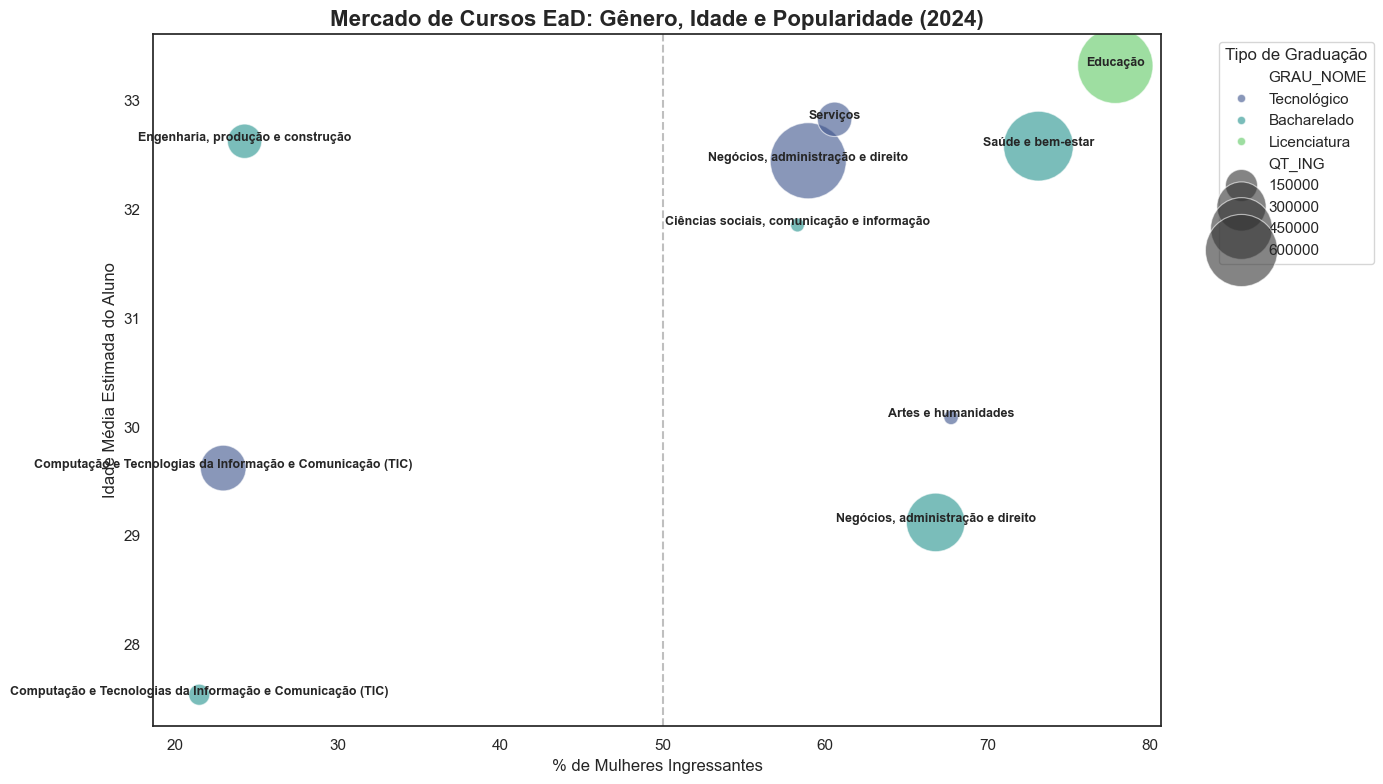

In [134]:
# 2. Cursos e Tipos de Graduação mais procurados por Sexo e Idade média

# Mapeando os códigos de Grau Acadêmico  para nomes claros
grau_map = {1: 'Bacharelado', 2: 'Licenciatura', 3:'Tecnológico'}
df_c24['GRAU_NOME'] = df_c24['TP_GRAU_ACADEMICO'].map(grau_map)

# Estimativa da idade média (Cálculo Ponderado)
# Usando o ponto médio de cada faixa etária para estimar a média do curso
pesos_idade = {
    'QT_ING_0_17': 17, 'QT_ING_18_24': 21, 'QT_ING_25_29': 27,
    'QT_ING_30_34': 32, 'QT_ING_35_39': 37, 'QT_ING_40_49': 44.5,
    'QT_ING_50_59': 54.5, 'QT_ING_60_MAIS': 65
}

# Calculando a idade média ponderada para cada curso
df_c24['IDADE_POND'] = sum(df_c24[col] * idade for col, idade in pesos_idade.items()) / df_c24['QT_ING']

analise_curso = df_c24.groupby(['NO_CINE_AREA_GERAL', 'GRAU_NOME']).agg({
    'QT_ING': 'sum',
    'QT_ING_FEM': 'sum',
    'IDADE_POND': 'mean'
}).reset_index()

analise_curso['PCT_FEM'] = (analise_curso['QT_ING_FEM'] /analise_curso['QT_ING']) * 100

analise_curso = analise_curso[analise_curso['QT_ING'] > analise_curso['QT_ING'].quantile(0.5)]

plt.figure(figsize=(14, 8))
sns.set_style("white")

scatter = sns.scatterplot(
    data=analise_curso,
    x='PCT_FEM',
    y='IDADE_POND',
    size='QT_ING',
    hue='GRAU_NOME',
    sizes=(100, 3000), # Define o tamanho das bolhas
    alpha=0.6,
    palette='viridis'
)

plt.axvline(50, color='grey', linestyle='--', alpha=0.5)
plt.title('Mercado de Cursos EaD: Gênero, Idade e Popularidade (2024)', fontsize=16, fontweight='bold')
plt.xlabel('% de Mulheres Ingressantes', fontsize=12)
plt.ylabel('Idade Média Estimada do Aluno', fontsize=12)
plt.legend(title='Tipo de Graduação', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionando nomes ás bolhas mais importantes (Top 10 volumes)
top_10 = analise_curso.nlargest(10, 'QT_ING')
for i, row in top_10.iterrows():
    plt.text(row['PCT_FEM'], row['IDADE_POND'], row['NO_CINE_AREA_GERAL'],
             fontsize=9, ha='center', fontweight='semibold')

plt.tight_layout()
plt.show()

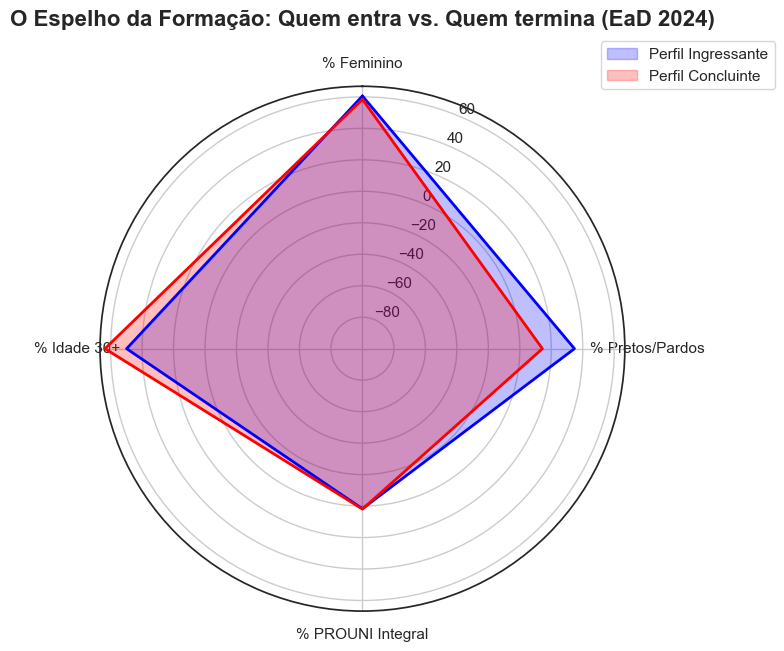

In [135]:
# Perfil do Ingressante vs. Perfil do Concluinte (EaD 2024)

def calcular_perfil(suffix):
    total = df_c24[f'QT_{suffix}'].sum()

    p_fem = (df_c24[f'QT_{suffix}_FEM'].sum() /  total) * 100
    p_negro = ((df_c24[f'QT_{suffix}_PRETA'].sum() + df_c24[f'QT_{suffix}_PARDA'].sum()) / total) * 100
    p_prouni = (df_c24[f'QT_{suffix}_PROUNII'].sum() / total) * 100

    idades_30_mais = [f'QT_{suffix}_30_34', f'QT_{suffix}_35_39', f'QT_{suffix}_40_49', f'QT_{suffix}_50_59', f'QT_{suffix}_60_MAIS']
    p_maduro = (df_c24[idades_30_mais].sum().sum() / total) * 100

    return [p_fem, p_negro, p_prouni, p_maduro]

labels = ['% Feminino', '% Pretos/Pardos', '% PROUNI Integral', '% Idade 30+']
ingressante = calcular_perfil('ING')
concluinte = calcular_perfil('CONC')

# Gráfico de radar
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
ingressante += ingressante[:1]
concluinte += concluinte[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

ax.fill(angles, ingressante, color='blue', alpha=0.25, label='Perfil Ingressante')
ax.plot(angles, ingressante, color='blue', linewidth=2)

ax.fill(angles, concluinte, color='red', alpha=0.25, label='Perfil Concluinte')
ax.plot(angles, concluinte, color='red', linewidth=2)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0-100)

plt.title('O Espelho da Formação: Quem entra vs. Quem termina (EaD 2024)', size=16, fontweight='bold', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
    

In [136]:
# Calcular evasão apenas onde há matrículados (Evitando divisão por zero)

mask_com_alunos = df_c24['QT_MAT'] > 0


df_c24['TAXA_EVASAO_CURSO'] = 0.0
df_c24.loc[mask_com_alunos, 'TAXA_EVASAO_CURSO'] = ((df_c24['QT_SIT_DESVINCULADO'] + df_c24['QT_SIT_TRANCADA']) / df_c24['QT_MAT']) * 100

df_c24['PCT_FEM'] = 0.0
df_c24.loc[mask_com_alunos, 'PCT_FEM'] = (df_c24['QT_MAT_FEM'] / df_c24['QT_MAT']) * 100

condicoes = [(df_c24['QT_MAT'] == 0), (df_c24['PCT_FEM'] > 70), (df_c24['PCT_FEM'] < 30)]

escolhas = ['Sem Matrículas', 'Majoritariamente Feminino', 'Majoritariamente Masculino']

df_c24['PERFIL_GENERO'] = np.select(condicoes, escolhas, default='Misto')

comparativo_evasao = df_c24.groupby('PERFIL_GENERO', observed=False)['TAXA_EVASAO_CURSO'].mean().sort_values(ascending=False).reset_index()


In [137]:
comparativo_evasao

,PERFIL_GENERO,TAXA_EVASAO_CURSO
0,Majoritariamente Feminino,82.015547
1,Misto,75.650944
2,Majoritariamente Masculino,75.138854
3,Sem Matrículas,0.000000


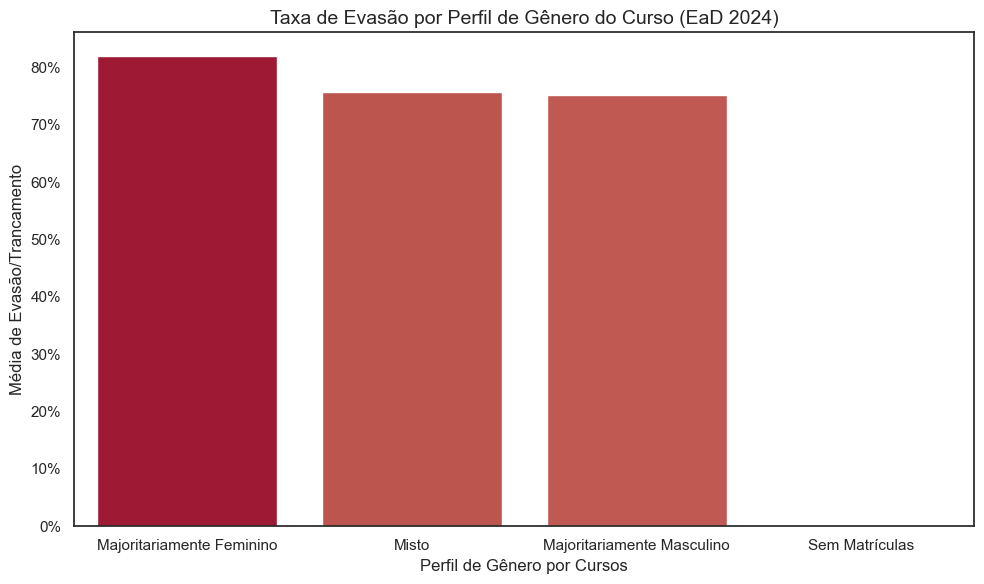

In [138]:
plt.figure(figsize=(10, 6))

sns.barplot(data=comparativo_evasao, x='PERFIL_GENERO', y= 'TAXA_EVASAO_CURSO', palette='coolwarm', hue='TAXA_EVASAO_CURSO', legend=False)
plt.title('Taxa de Evasão por Perfil de Gênero do Curso (EaD 2024)', fontsize=14)
plt.ylabel('Média de Evasão/Trancamento')
plt.xlabel('Perfil de Gênero por Cursos')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.show()

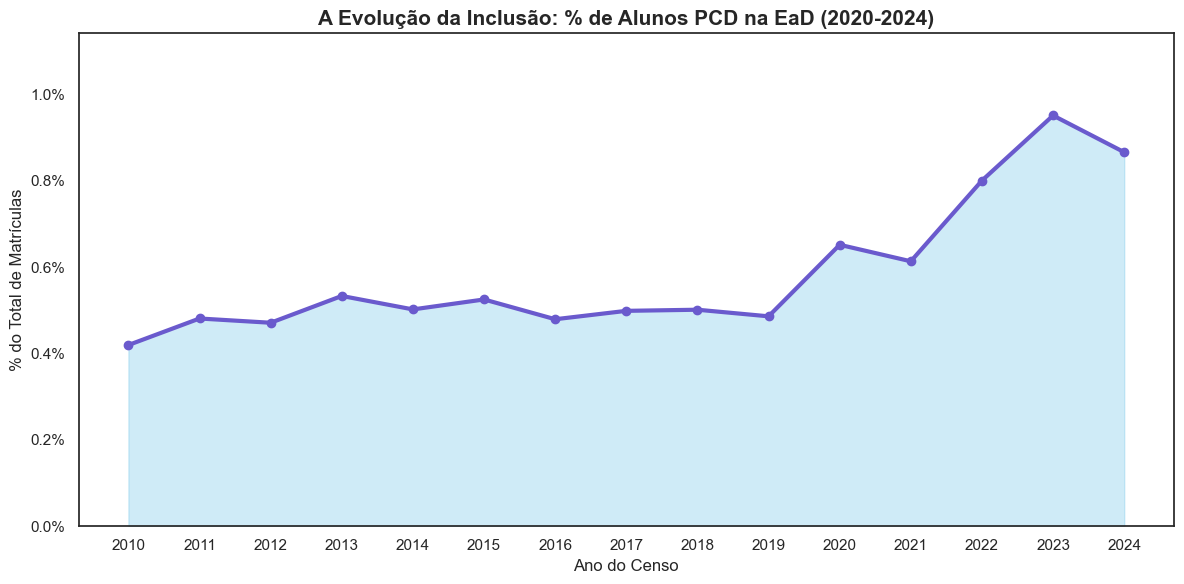

In [143]:
# Evolução temporal de matrículas PCD
pcd_temporal = df_c.groupby('NU_ANO_CENSO', observed=False).agg({
    'QT_MAT_DEFICIENTE': 'sum',
    'QT_MAT': 'sum'
}).reset_index()

pcd_temporal['PCT_PCD'] = (pcd_temporal['QT_MAT_DEFICIENTE'] / pcd_temporal['QT_MAT']) * 100

plt.figure(figsize=(12, 6))

plt.fill_between(pcd_temporal['NU_ANO_CENSO'], pcd_temporal['PCT_PCD'], color="skyblue", alpha=0.4)
plt.plot(pcd_temporal['NU_ANO_CENSO'], pcd_temporal['PCT_PCD'], color="Slateblue", marker='o', linewidth=3)

plt.title('A Evolução da Inclusão: % de Alunos PCD na EaD (2020-2024)', fontsize=15, fontweight='bold')
plt.ylabel('% do Total de Matrículas')
plt.xlabel('Ano do Censo')
plt.xticks(pcd_temporal['NU_ANO_CENSO'])
plt.ylim(0, pcd_temporal['PCT_PCD'].max() * 1.2)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

plt.tight_layout()
plt.savefig(fname='evolucao_inclusao', dpi=300, bbox_inches='tight')
plt.show()


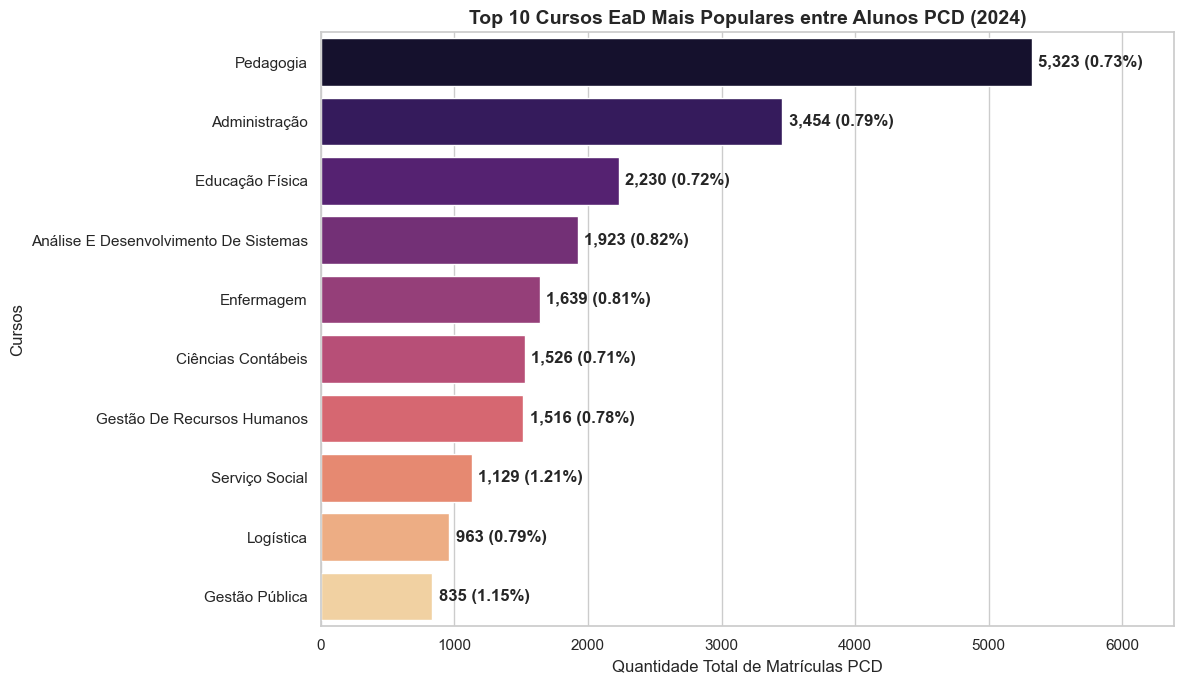

In [145]:
# Top 10 Cursos com Maior Presença de PCDs (2024)

top_pcd = df_c24.groupby('NO_CURSO').agg({
    'QT_MAT_DEFICIENTE': 'sum',
    'QT_MAT': 'sum'
}).reset_index()

top_pcd['PCT_PCD_CURSO'] = (top_pcd['QT_MAT_DEFICIENTE'] / top_pcd['QT_MAT']) * 100

top_10_pcd = top_pcd.sort_values('QT_MAT_DEFICIENTE', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


grafico =  sns.barplot(
    data=top_10_pcd,
    x = 'QT_MAT_DEFICIENTE',
    y = 'NO_CURSO',
    palette='magma',
    hue = 'NO_CURSO'
)

# Adicionando rótulos com a quantidade e o percentual de representatividade
for i, (valor, pct) in enumerate(zip(top_10_pcd['QT_MAT_DEFICIENTE'], top_10_pcd['PCT_PCD_CURSO'])):
    plt.text(valor + 50, i, f'{int(valor):,} ({pct:.2f}%)', va='center', fontweight='bold')

plt.title('Top 10 Cursos EaD Mais Populares entre Alunos PCD (2024)', fontsize=14, fontweight='bold')
plt.xlabel('Quantidade Total de Matrículas PCD')
plt.ylabel('Cursos')

# Ajustando o limite do eixo X para caber os textos
plt.xlim(0, top_10_pcd['QT_MAT_DEFICIENTE'].max() * 1.2)

plt.tight_layout()
plt.savefig('top_10_cursos_polulares_pcd_2024', dpi=300, bbox_inches='tight')
plt.show()


**Funil de Jornada - Homens vs. Mulheres**

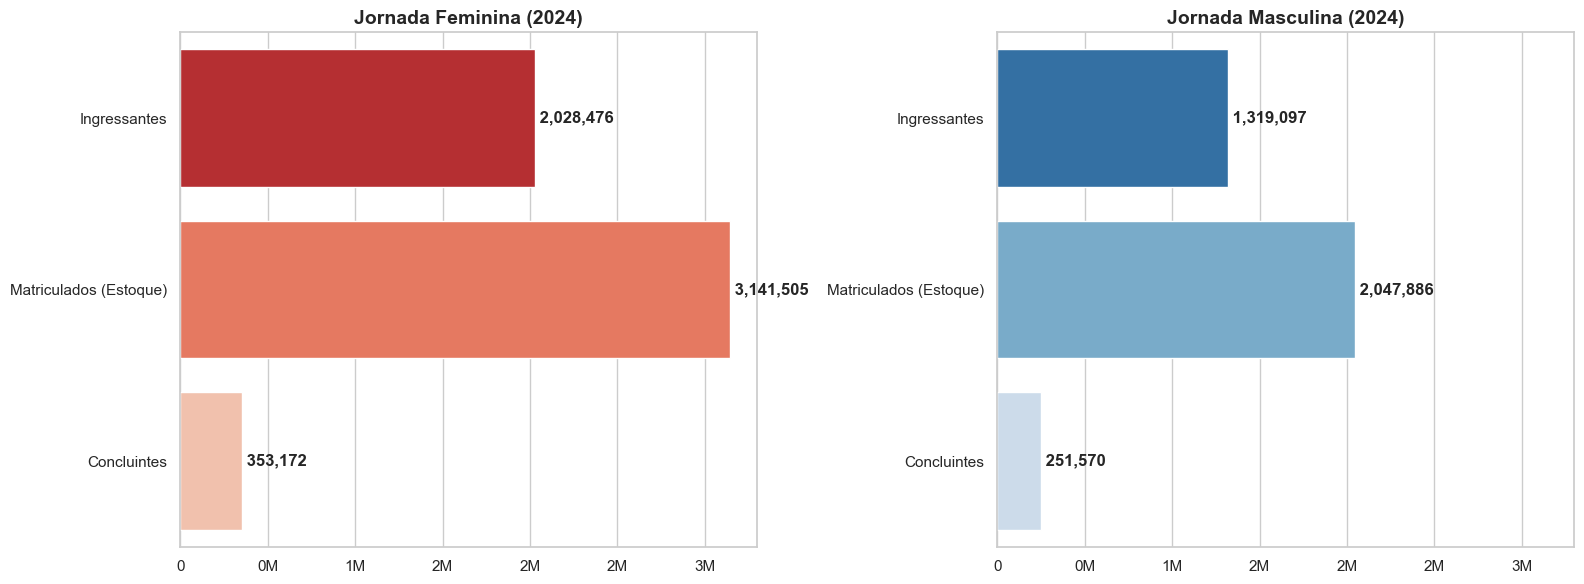

In [148]:
def funil_genero(genero_prefix):
    return [
        df_c24[f'QT_ING_{genero_prefix}'].sum(),
        df_c24[f'QT_MAT_{genero_prefix}'].sum(),
        df_c24[f'QT_CONC_{genero_prefix}'].sum()
    ]

etapas = ['Ingressantes', 'Matriculados (Estoque)', 'Concluintes']
dados_fem = funil_genero('FEM')
dados_masc = funil_genero('MASC')

# Criando subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)


# Funil Feminino
sns.barplot(x=dados_fem, y=etapas, ax=ax1, palette='Reds_r', hue=etapas, legend=False)
ax1.set_title('Jornada Feminina (2024)', fontsize=14, fontweight='bold')

# Funil Masculino
sns.barplot(x=dados_masc, y=etapas, ax=ax2, palette='Blues_r', hue=etapas, legend=False)
ax2.set_title('Jornada Masculina (2024)', fontsize=14, fontweight='bold')

#Add rótulos de valores
for ax, dados in zip([ax1, ax2], [dados_fem, dados_masc]):
    for i, v in enumerate(dados):
        ax.text(v, i, f' {int(v):,}', va='center', fontweight='bold')

plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(milhoes))
plt.tight_layout()
plt.savefig('jornada_genero_2024.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Funil de Perfil Etário (2020 vs. 2024)

age_ing = ['QT_ING_0_17','QT_ING_18_24', 'QT_ING_25_29', 'QT_ING_30_34', 'QT_ING_35_39', 'QT_ING_40_49', 'QT_ING_50_59', 'QT_ING_60_MAIS']

labels_idade = ['0-17', '18-24', '25-29', '30-34', '35-39', '40-49', '50-59', '60+']

dados_2020 = df_c[df_c['NU_ANO_CENSO'] == 2020][age_ing].sum().values
dados_2024 = df_c[df_c['NU_ANO_CENSO'] == 2024][age_ing].sum().values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

#Funil 2020
sns.barplot(x=dados_2020, y=labels_idade, ax=ax1, palette='viridis', hue=labels_idade, legend=False)
ax1.set_title('Perfil de Idade no Ingresso (2020)', fontsize=14, pad=20)
ax1.invert_xaxis() # Efeito espelho


#Funil 2024
sns.barplot(x=dados_2024, y=labels_idade, ax=ax2, palette='viridis', hue=labels_idade, legend=False)
ax2.set_title('Perfil de Idade no Ingresso (2024)', fontsize=14, pad=20)

for ax in [ax1, ax2]:
        # Formatar Milhões
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(milhoes))

        ax.spines['left' if ax == ax2 else 'right'].set_visible(False)
       
        # Redução de marcar do eixo x para não amontoar
        #ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=4))

for ax, dados in zip([ax1, ax2], [dados_2020, dados_2024]):
    for i, v in enumerate(dados):
        offset = -v*0.02 if ax == ax1 else v*0.02
        aligh = 'right' if ax == ax1 else 'left'
        ax.text(v + offset, i, f'{int(v):,}', va='center', fontweight='bold', ha=align)
        

plt.suptitle('Panorama Etário da Porta de Entrada EaD', fontsize=18, y=1.02)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.show()


In [ ]:
df_extremos = df_c[df_c['NU_ANO_CENSO'].isin([2020, 2024])].copy()

df_extremos['QT_ING_NEGROS'] = df_extremos['QT_ING_PRETA'] + df_extremos['QT_ING_PARDA']

raca_area = df_extremos.groupby(['NU_ANO_CENSO', 'SG_UF']).agg({
    'QT_ING_BRANCA':'sum',
    'QT_ING_NEGROS':'sum',
    'QT_ING_AMARELA':'sum',
    'QT_ING_INDIGENA':'sum'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
cores = ['#3498db', '#e67e22', '#f1c40f', '#2ecc71']
labels = ['Branca', 'Negra (Preta+Parda)', 'Amarela', 'Indígena']

for i, ano in enumerate([2020, 2024]):
    dados_ano = raca_area[raca_area['NU_ANO_CENSO'] == ano].copy()
    dados_ano['Total'] = dados_ano[['QT_ING_BRANCA', 'QT_ING_NEGROS', 'QT_ING_AMARELA', 'QT_ING_INDIGENA']].sum(axis=1)
    dados_ano = dados_ano.sort_values('Total', ascending=True)

    axes[i].stackplot(
        dados_ano['SG_UF'],
        dados_ano['QT_ING_BRANCA'],
        dados_ano['QT_ING_NEGROS'],
        dados_ano['QT_ING_AMARELA'],
        dados_ano['QT_ING_INDIGENA'],
        labels = labels,
        colors = cores,
        alpha = 0.8
    )

    axes[i].set_title(f'Perfil Racial de Integrantes por Estado - {ano}',fontsize=16, fontweight='bold')
    axes[i].set_ylabel('Volume de Ingressos')
    axes[i].legend(loc='upper left', fontsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.xlabel('Estados (Ordenados por Volume Total)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# df.to_csv('censo_ead_v2.csv', sep=';', encoding='ISO-8859-1', index=False)